In [1]:
import torch
import numpy as np
from transformers import RobertaTokenizer
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class CustomRoBERTaDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels, max_length):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [3]:
DATA_PATH = "data"
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 20
MAX_LENGTH = 32

In [4]:
# Check if a GPU is available and set the device accordingly

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [48]:
class CustomTransformerEncForSequenceCLS(torch.nn.Module):
    def __init__(self, d_model, nhead, ff, num_blocks, vocab_len, seq_len, device="cpu"):
        super().__init__()

        self.device = device
        self.d_model = d_model
        self.num_blocks = num_blocks
        self.vocab_len = vocab_len
        self.seq_len = seq_len
        self.nhead = nhead
        self.ff = ff

        self.emb = torch.nn.Embedding(self.vocab_len, self.d_model)
        self.pos_emb = torch.nn.Embedding(self.seq_len, self.d_model)

        self.transformer = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=self.nhead,
            dim_feedforward=self.ff,
            batch_first=True,
            dropout=0.7
        ), num_layers=self.num_blocks)

        self.out = torch.nn.Linear(self.d_model, 2)


    def forward(self, x):

        x = self.emb(x)
        x = x + self.pos_emb(torch.arange(self.seq_len).unsqueeze(0).to(self.device))[:, :x.shape[1]]

        res = self.transformer(x) # (batch, seq_len, d_model)
        res = self.out(res.view(-1, self.d_model)).view(-1, self.seq_len, 2)

        return res

In [49]:
model = CustomTransformerEncForSequenceCLS(d_model=128,
                                           nhead=4,
                                           ff=512,
                                           num_blocks=1,
                                           vocab_len=tokenizer.vocab_size,
                                           seq_len=MAX_LENGTH,
                                           device=device)

In [50]:
model.to(device)

CustomTransformerEncForSequenceCLS(
  (emb): Embedding(50265, 128)
  (pos_emb): Embedding(32, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.7, inplace=False)
        (dropout2): Dropout(p=0.7, inplace=False)
      )
    )
  )
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [51]:
test_dataset = torch.load(os.path.join(DATA_PATH, "processed_test_dataset.pt"))
train_dataset = torch.load(os.path.join(DATA_PATH, "processed_train_dataset.pt"))

In [52]:
test_dataload = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)
train_dataload = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

In [53]:
# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_f = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1, 30]).to(torch.float64).to(device))

history_loss = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in tqdm(train_dataload):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)
        
        
        # Forward pass
        outputs = model(x=input_ids).to(torch.float64)

        loss = loss_f(outputs.view(-1, 2), labels.view(-1))
        total_loss += loss.item()
        history_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataload)

    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}, Average Loss: {avg_loss:.4f}")

100%|██████████| 48/48 [00:02<00:00, 18.07it/s]



Epoch 1/20, Average Loss: 0.6732


100%|██████████| 48/48 [00:02<00:00, 19.51it/s]



Epoch 2/20, Average Loss: 0.6105


100%|██████████| 48/48 [00:02<00:00, 17.37it/s]



Epoch 3/20, Average Loss: 0.5802


100%|██████████| 48/48 [00:02<00:00, 19.02it/s]



Epoch 4/20, Average Loss: 0.5554


100%|██████████| 48/48 [00:02<00:00, 19.61it/s]



Epoch 5/20, Average Loss: 0.5316


100%|██████████| 48/48 [00:02<00:00, 18.79it/s]



Epoch 6/20, Average Loss: 0.5042


100%|██████████| 48/48 [00:02<00:00, 18.08it/s]



Epoch 7/20, Average Loss: 0.4835


100%|██████████| 48/48 [00:02<00:00, 19.53it/s]



Epoch 8/20, Average Loss: 0.4623


100%|██████████| 48/48 [00:02<00:00, 19.70it/s]



Epoch 9/20, Average Loss: 0.4390


100%|██████████| 48/48 [00:02<00:00, 18.62it/s]



Epoch 10/20, Average Loss: 0.4224


100%|██████████| 48/48 [00:02<00:00, 17.93it/s]



Epoch 11/20, Average Loss: 0.4142


100%|██████████| 48/48 [00:02<00:00, 19.48it/s]



Epoch 12/20, Average Loss: 0.4000


100%|██████████| 48/48 [00:02<00:00, 19.02it/s]



Epoch 13/20, Average Loss: 0.3811


100%|██████████| 48/48 [00:02<00:00, 17.98it/s]



Epoch 14/20, Average Loss: 0.3738


100%|██████████| 48/48 [00:02<00:00, 17.18it/s]



Epoch 15/20, Average Loss: 0.3632


100%|██████████| 48/48 [00:02<00:00, 17.94it/s]



Epoch 16/20, Average Loss: 0.3536


100%|██████████| 48/48 [00:02<00:00, 18.59it/s]



Epoch 17/20, Average Loss: 0.3415


100%|██████████| 48/48 [00:02<00:00, 17.15it/s]



Epoch 18/20, Average Loss: 0.3332


100%|██████████| 48/48 [00:02<00:00, 18.39it/s]



Epoch 19/20, Average Loss: 0.3368


100%|██████████| 48/48 [00:02<00:00, 18.10it/s]


Epoch 20/20, Average Loss: 0.3237


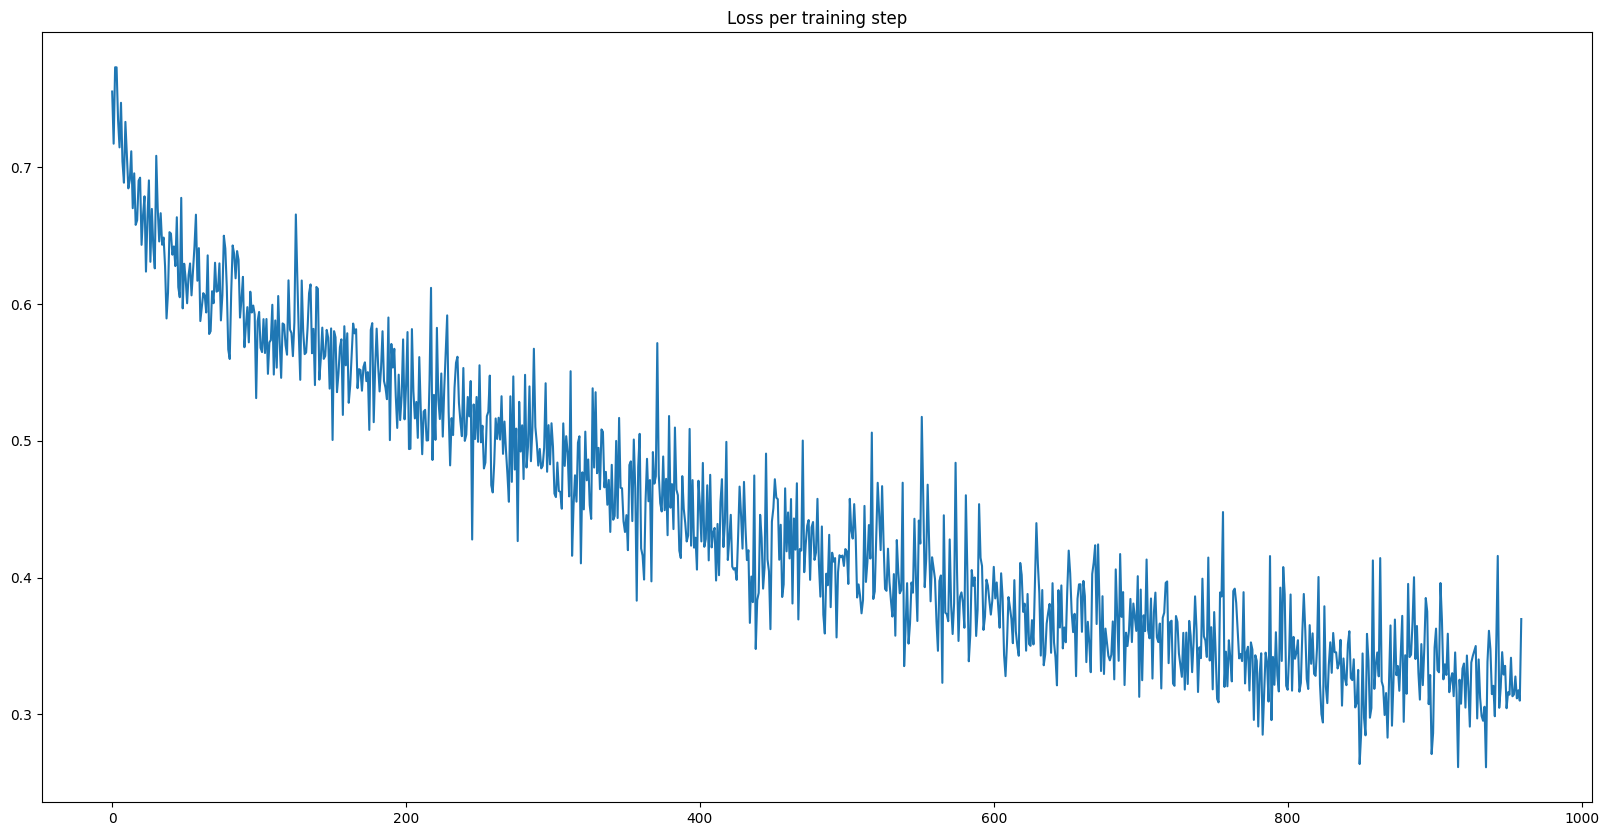

In [54]:
plt.figure(figsize=(20, 10))

plt.plot(history_loss)
plt.title("Loss per training step")
plt.show()

In [55]:
def acc(model, dataloader):
    model.eval()

    total_acc = 0

    for batch in iter(dataloader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)

        with torch.inference_mode():
            outputs = model(x=input_ids).to(torch.float64)

        outputs = torch.softmax(outputs, dim=2).argmax(dim=2)
        acc = (outputs == labels).to(float).mean()
        total_acc += acc

    total_acc /= len(dataloader)
    return total_acc

In [56]:
acc(model, train_dataload)

tensor(0.8080, dtype=torch.float64)

In [57]:
acc(model, test_dataload)

tensor(0.7674, dtype=torch.float64)

In [58]:
def avg_pos_true(model, dataloader):
    model.eval()

    total_pos_true = 0

    for batch in iter(dataloader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)


        with torch.inference_mode():
            outputs = model(x=input_ids).to(torch.float64)

        outputs = torch.softmax(outputs, dim=2).argmax(dim=2)[labels.to(torch.bool)]
        pos_true = (outputs == 1).to(float).mean()
        total_pos_true += pos_true

    total_pos_true /= len(dataloader)
    return total_pos_true

In [59]:
avg_pos_true(model, train_dataload)

tensor(0.9980, dtype=torch.float64)

In [60]:
avg_pos_true(model, test_dataload)

tensor(0.6705, dtype=torch.float64)

In [61]:
torch.save(model, os.path.join(DATA_PATH, "models", "custom_transformer_trained.pt"))